In [2]:
from astroquery.gaia import Gaia
import pyvo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
""" get the clean DA wds from Napiwotski+2020
"""
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select da.Name, da.GaiaDR2, da.Teff as SPYTeff, da.logg as SPYlogg, da.Rem, objects.FileName
        from \"J/A+A/638/A131/tablec2\" as da
        join \"J/A+A/638/A131/objects\" as objects
        on da.Name = objects.Name
        where da.Rem = ' '
        """
table = tap_service.search(QUERY).to_table().to_pandas()

In [4]:
""" cross-match against Gaia
"""
QUERY = f"""select dr2.dr2_source_id as GaiaDR2, gaia.*
        from gaiadr3.gaia_source as gaia
        join gaiadr3.dr2_neighbourhood as dr2
        on gaia.source_id = dr2.dr3_source_id
        where dr2.dr2_source_id in {tuple(table.GaiaDR2)}
        """
gaia_table = Gaia.launch_job_async(QUERY).get_results().to_pandas()
full_table = pd.merge(table, gaia_table, on="GaiaDR2")
full_table['FileName'] = full_table['FileName'].astype(str) + '.gz'

INFO: Query finished. [astroquery.utils.tap.core]


1186

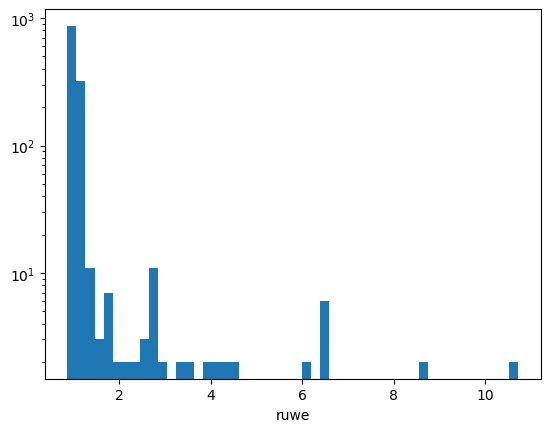

In [5]:
""" check RUWE to mitigate binary contamination
"""
plt.hist(full_table.ruwe, bins = 50)
plt.xlabel('ruwe')
plt.yscale('log')

full_table = full_table.query("ruwe < 1.25")
len(full_table)

In [7]:
""" save to a file that will be filtered against when measuring vstark
"""
stark_table = full_table[['Name', 'SOURCE_ID', 'FileName']]
stark_table.to_csv('../data/processed/good_spy.csv')